In [1]:
from llm_mri.LLM_MRI import LLM_MRI


/home/lipecorradini/.cache/pypoetry/virtualenvs/llm-mri-RE74i_Ji-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing necessary packages to visualize the library's figures. 

In [2]:
import matplotlib.pyplot as plt
from datasets import load_dataset, features, ClassLabel, Dataset

Loading Emotions Dataset from Hugging Face hub

In [3]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
data = load_dataset("csv", data_files=dataset_url, sep=";", 
                               names=["text", "label"], split='train[:1%]')

## Pre-processing

To evaluate the model on LLM-MRI, it is recommended to use a balanced dataset, so that different categories can be analyzed more clearly on the graph visualization.

In [4]:
emotions_df = data.to_pandas()
emotions_df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
emotions_df['label'].value_counts()

label
joy         61
sadness     38
anger       26
fear        15
love        12
surprise     8
Name: count, dtype: int64

To apply our normalization, we are going to pick 8 examples total by class

In [6]:
balanced_emotions_df = emotions_df.groupby('label').apply(
    lambda group: group.head(8)
).reset_index(drop=True)


/tmp/ipykernel_32764/1633678573.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_emotions_df = emotions_df.groupby('label').apply(


Having our balanced data, let's turn it into a HF Dataset to proceed with the analysis 

In [7]:
emotions = Dataset.from_pandas(balanced_emotions_df)

As the "Emotions" Dataset did not contain the "label" category, it is necessary to get the labels and turn into 'ClassLabel' type.

In [8]:
label_feature = emotions.features["label"]

class_names  = emotions.unique("label")
class_feature = features.ClassLabel(names=sorted(class_names))
emotions = emotions.map(lambda str_value: {"label": class_feature.str2int(str_value)}, input_columns="label")

emotions = emotions.cast(features.Features({
    "label": class_feature,
    "text": emotions.features["text"]}))


Casting the dataset: 100%|██████████| 48/48 [00:00<00:00, 9545.62 examples/s]


In [9]:
model_ckpt = "distilbert-base-uncased"

In [10]:
llm_mri = LLM_MRI(model=model_ckpt, device="cpu", dataset=emotions)

Map: 100%|██████████| 48/48 [00:00<00:00, 6912.03 examples/s]


## Process Areas

When the user provides a model and a corpus for activation analysis, the _process_activation_areas_ function extracts all hidden states from the model, enabling the user to visualize them as tensors. This method also reduces each hidden layers dimensionalities, building a _nxn_ representation grid.

In [11]:
llm_mri.process_activation_areas(map_dimension = 10)

Map: 100%|██████████| 48/48 [00:02<00:00, 18.28 examples/s]


## Layer Image

The _get_layer_image_ function allows the user to visualize activations in neuron regions produced by the model's dimensionality reduction. Each cell represents a different region in a specified layer provided by the user. By passing a category as a parameter, the function enables visualization of the activations in the specified layer for the given category.

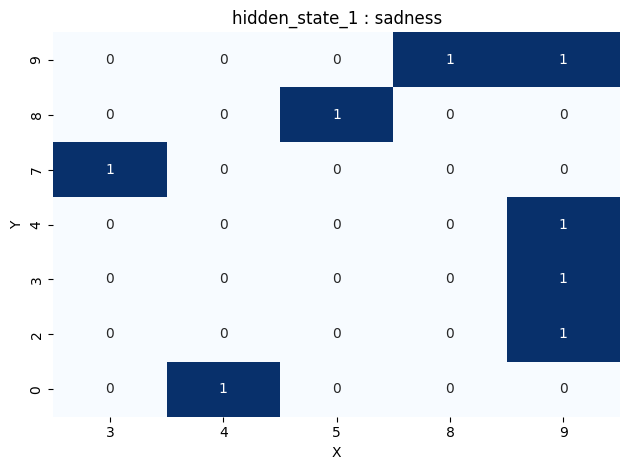

In [12]:
fig = llm_mri.get_layer_image(layer=1, category="sadness")
plt.tight_layout()
plt.show()

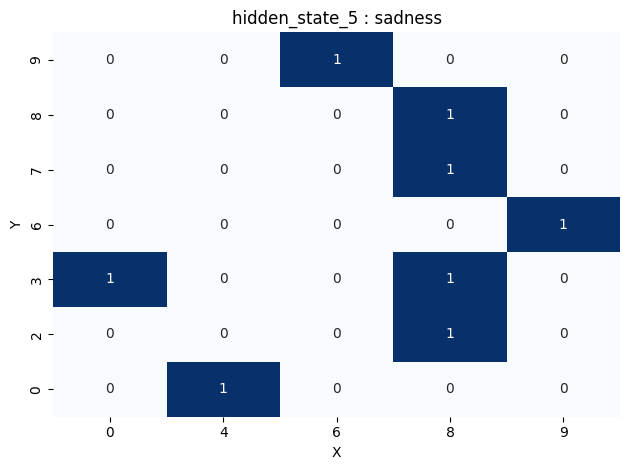

In [13]:
fig = llm_mri.get_layer_image(layer=5, category="sadness")
plt.tight_layout()
plt.show()

## Graph visualization

The _get_graph()_ function enables the user to obtain a Networkx graph representing the neuron activations in the hidden states. Each set of nodes represents activations in a specific hidden layer, while the edges between nodes indicate that documents with the specified label activated both regions.

The _get_graph_image()_ function generates an image of the graph, allowing it to be visualized by the user.

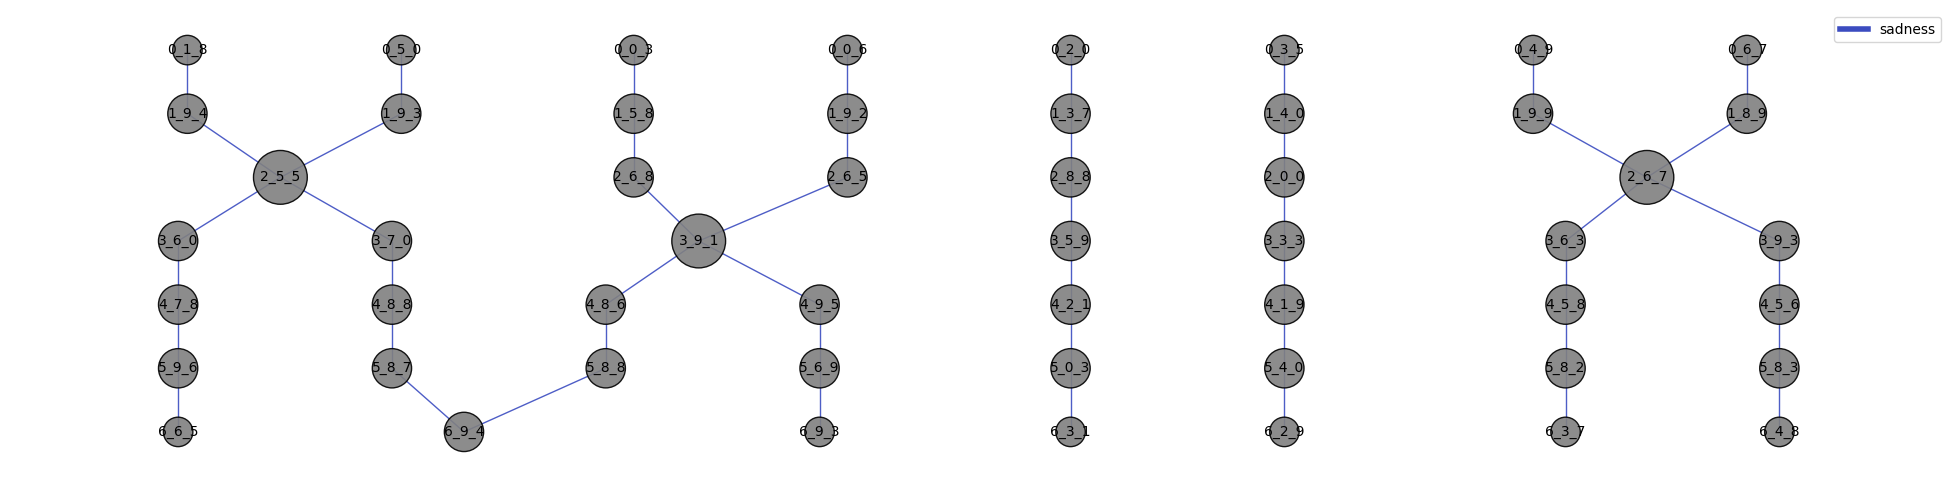

In [14]:
g = llm_mri.get_graph("sadness")

g_img = llm_mri.get_graph_image(g)
plt.box(False)
plt.show()

Here, we can see the graph visualization for the "sadness" category. Each cell represents an activation region, in the format _hiddenstate_x_y_. 

By getting the graph, it is possible to apply complex networks measurements to evaluate more densely connected nodes and regions. With that, we can evaluate the nodes with the highest centralities, identify clusters, and apply other metrics to enhance the graph's understanding.

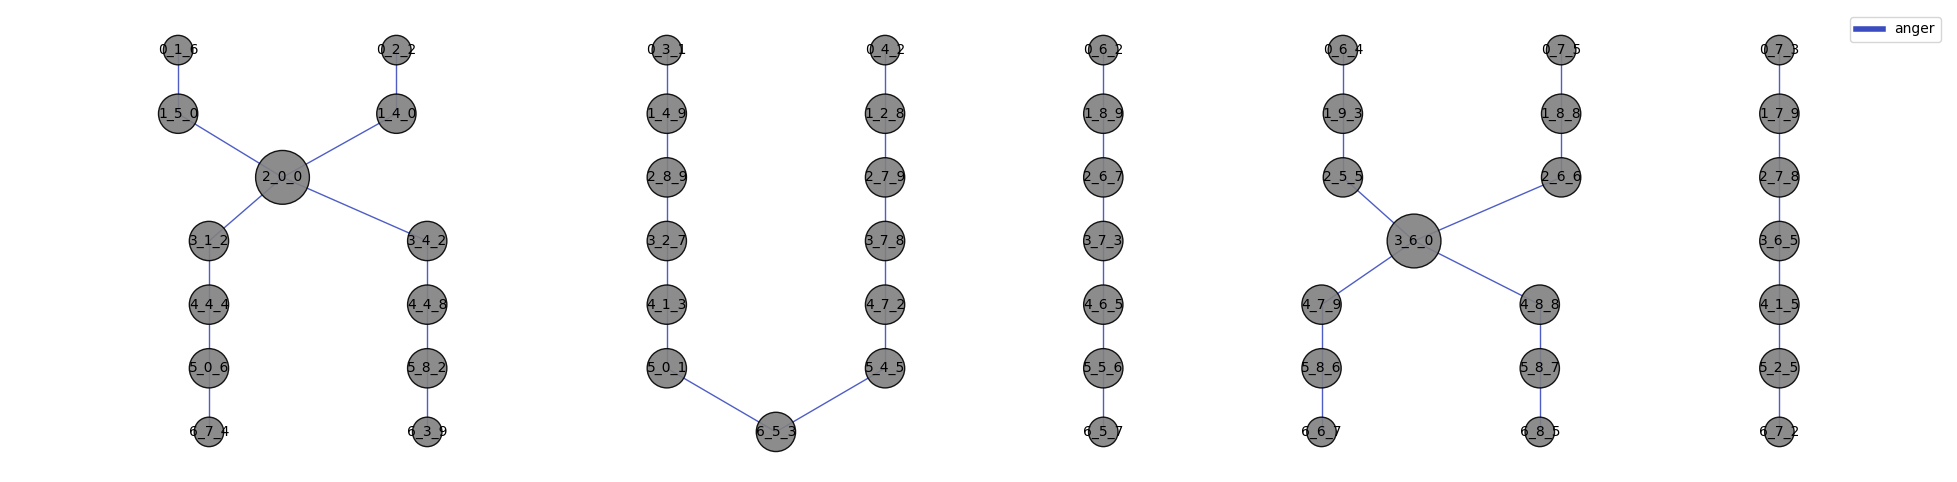

In [15]:
g = llm_mri.get_graph("anger")

g_img = llm_mri.get_graph_image(g)
plt.box(False)
plt.show()

On the image above, it is possible to visualize the graph representation for the "anger" activation regions.

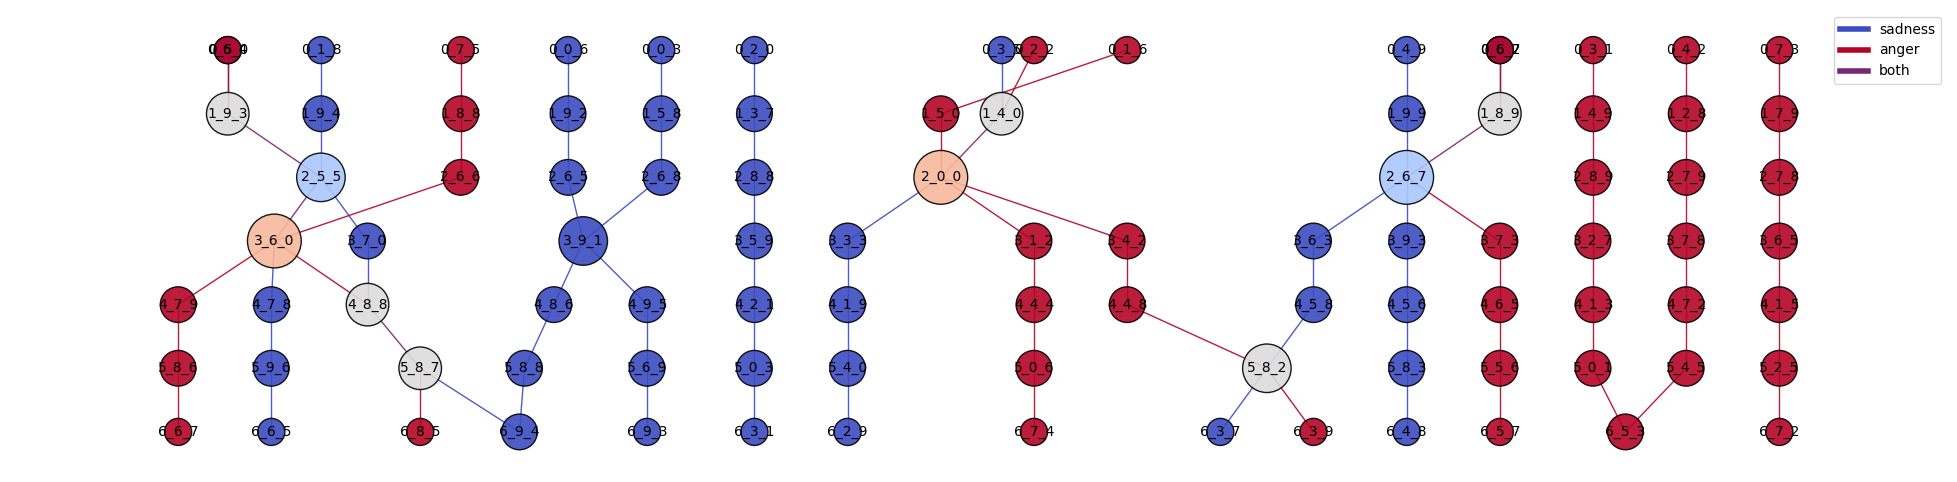

In [16]:
g_composed = llm_mri.get_composed_graph("sadness", "anger")
g_composed_img = llm_mri.get_graph_image(g_composed)

plt.box(False)
plt.show()

Through the _get_composed_graph()_ method, the user is also able to get a composed visualization of two different categories. By setting a category, each edge is colored based on the designed category, so the user is able to see which document label activated each region. On the image above, the blue color refers to the "anger" documents activations, while the green color shows "sadness" activations, and orange represent regions activated by both categories.

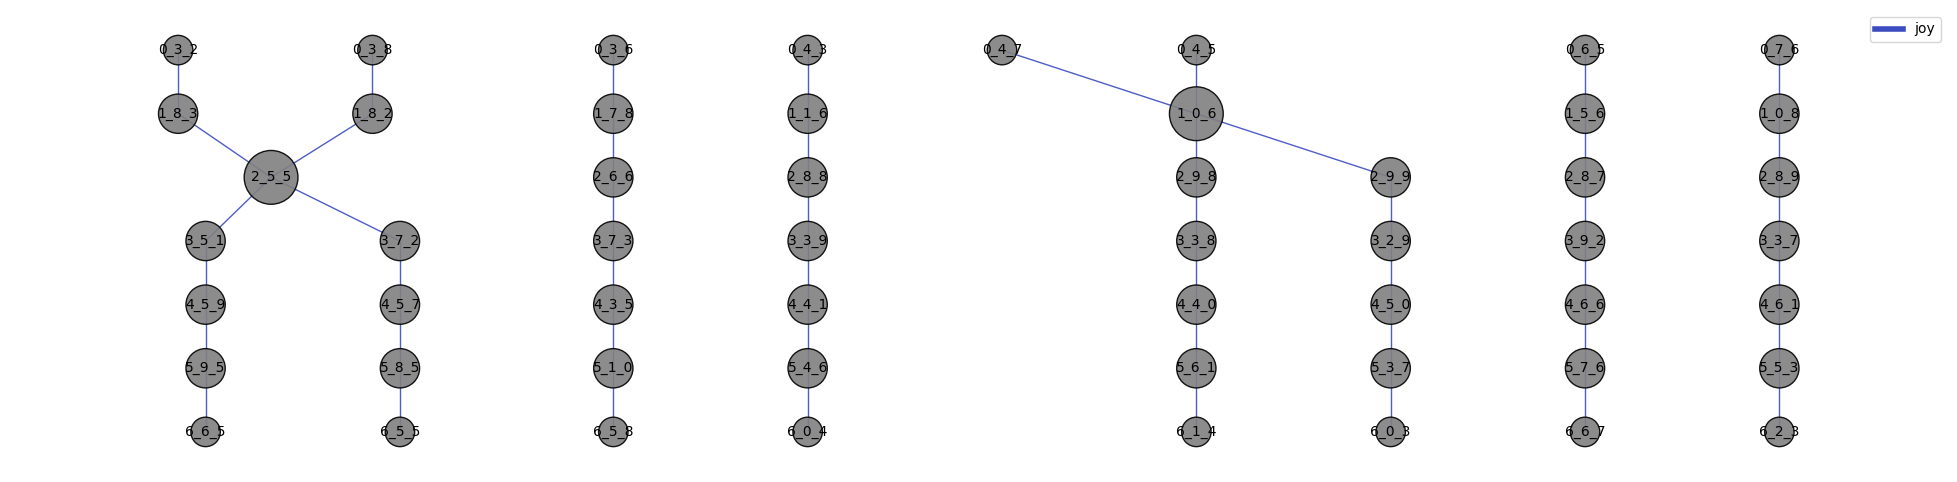

In [17]:
g = llm_mri.get_graph("joy")
img = llm_mri.get_graph_image(g)

plt.box(False)
plt.show()

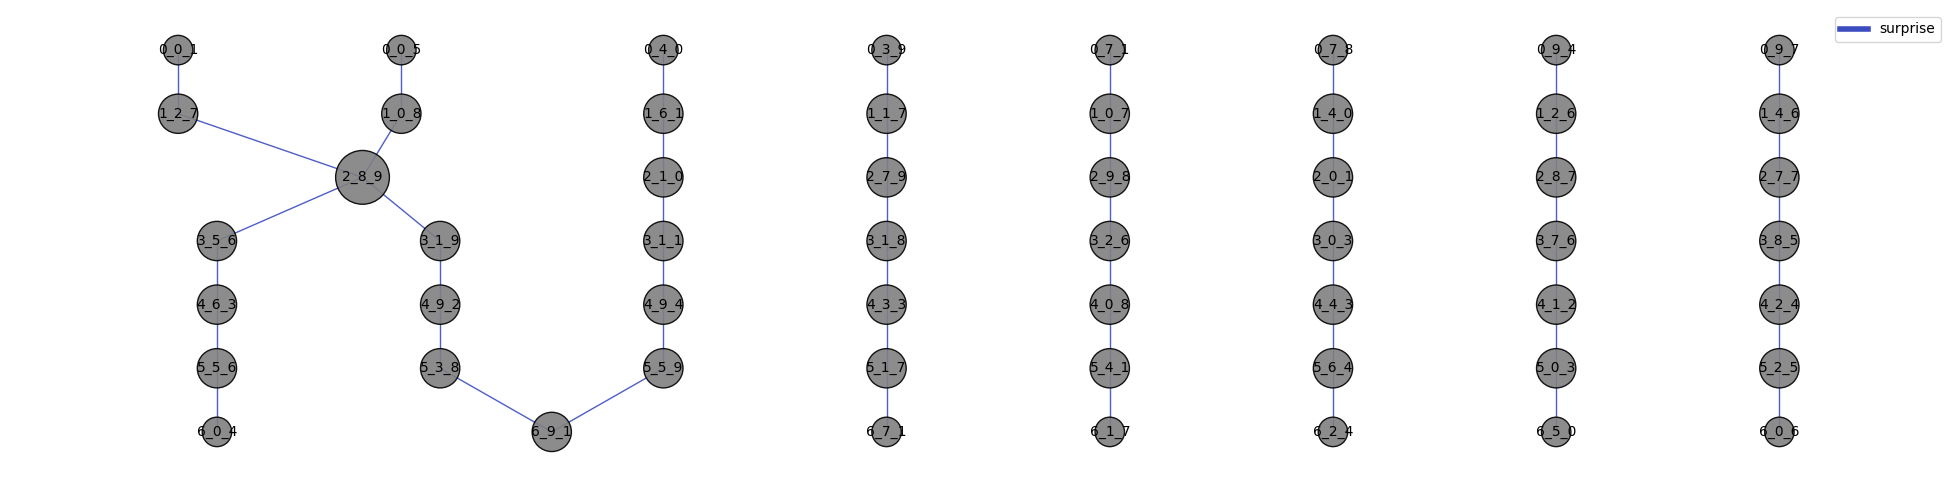

In [18]:
g = llm_mri.get_graph("surprise")
img = llm_mri.get_graph_image(g)

plt.box(False)
plt.show()

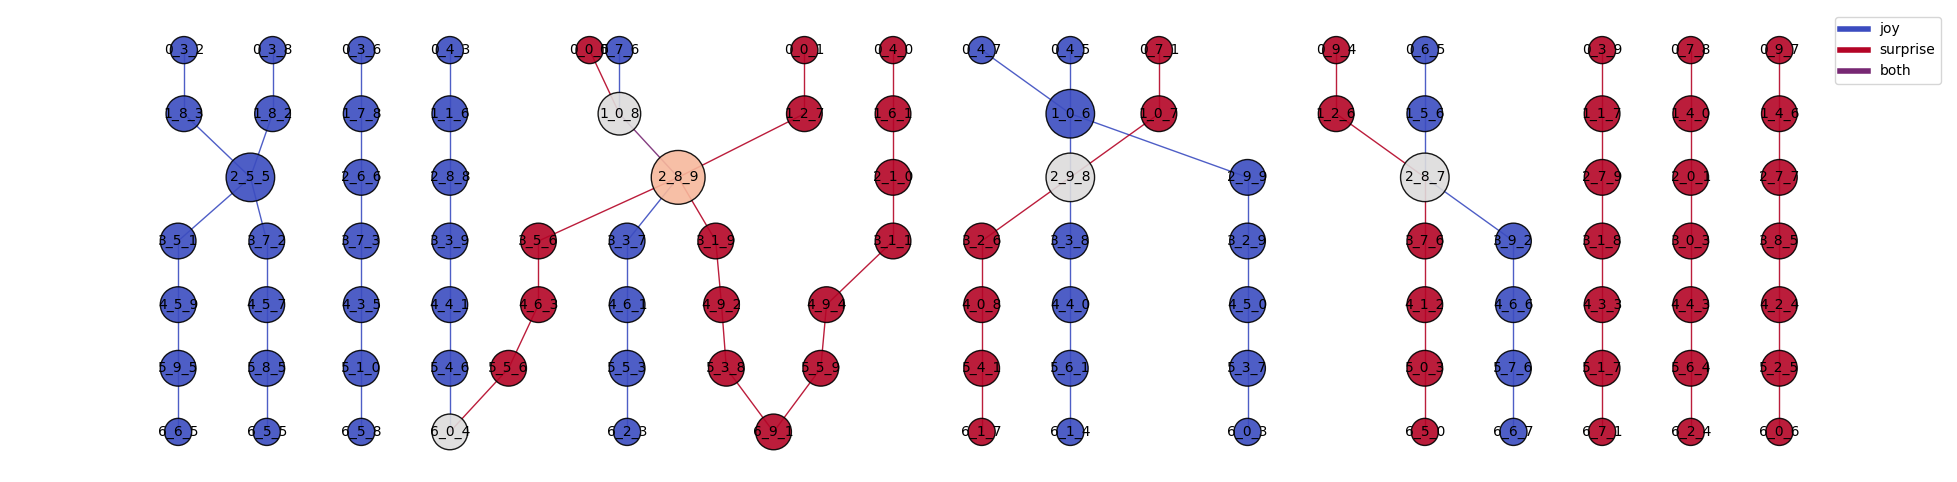

In [19]:
g_joy_surprise = llm_mri.get_composed_graph("joy", "surprise")
g_joy_surprise_img = llm_mri.get_graph_image(g_joy_surprise)

plt.box(False)
plt.show()

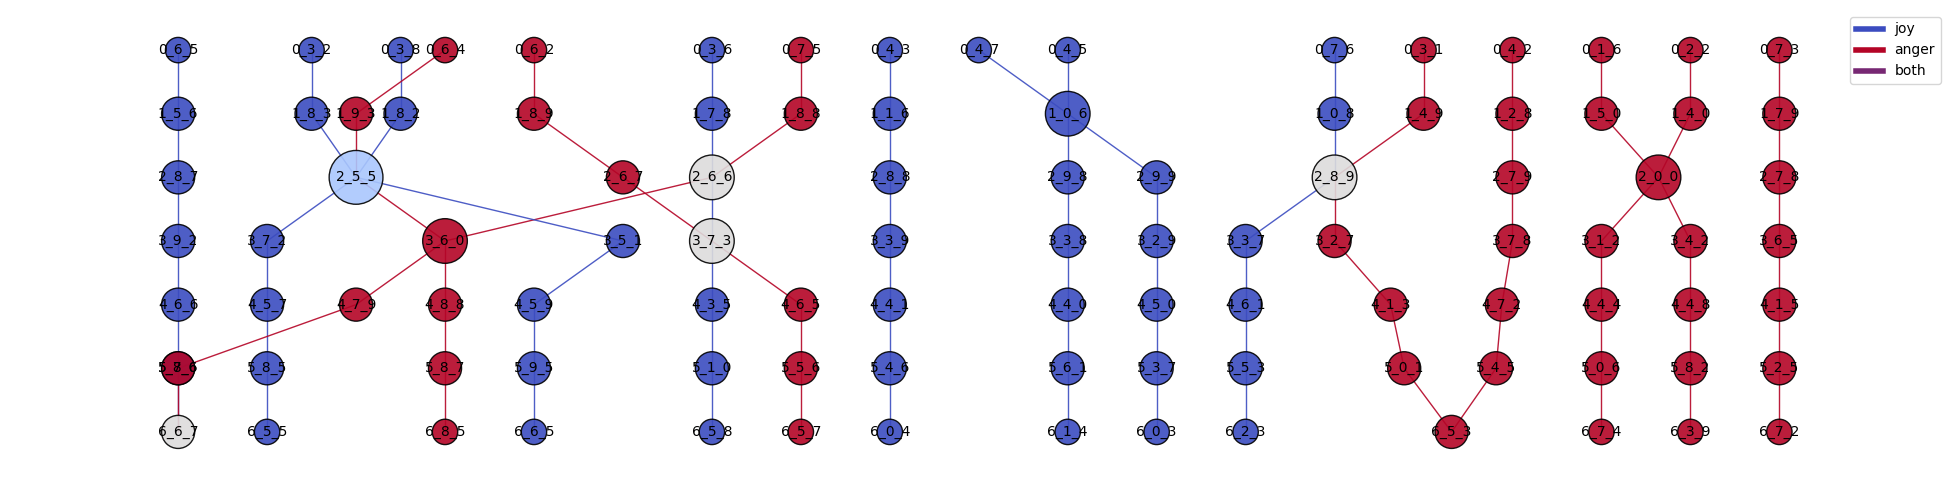

In [20]:
g_joy_anger = llm_mri.get_composed_graph("joy", "anger")
g_joy_anger_img = llm_mri.get_graph_image(g_joy_anger)

plt.box(False)
plt.show()